# 10강. 나를 찾아줘 - Class Activation Map 만들기
## 10-1. 들어가며
### 디렉토리 생성
![디렉토리 생성](https://user-images.githubusercontent.com/116326867/215677600-9fe5fd62-4771-45b0-827b-c0697d465ca0.png)

## 10-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기
- CAM(Class Activation Map) : 특성을 추출하는 CNN 네트워크 + GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer) vs. Grad-CAM : CNN 네트워크
- CAM은 클래스에 대한 활성화 정도를 나타낸 지도로, 기본적으로 분류(classfication)를 수행하는 모델이어야 한다. 하지만 최종적으로는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이 목표이므로 위치 정보가 기록된 데이터가 함께 있어야 한다.  

- 데이터셋 : [Tensorflow stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs?hl=ko) - 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 바운딩 박스(bounding box) 정보를 포함한다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
# GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


- stanford_dogs 데이터셋 구성 : 12,000장의 학습용 데이터셋과 8,580장의 평가용 데이터셋

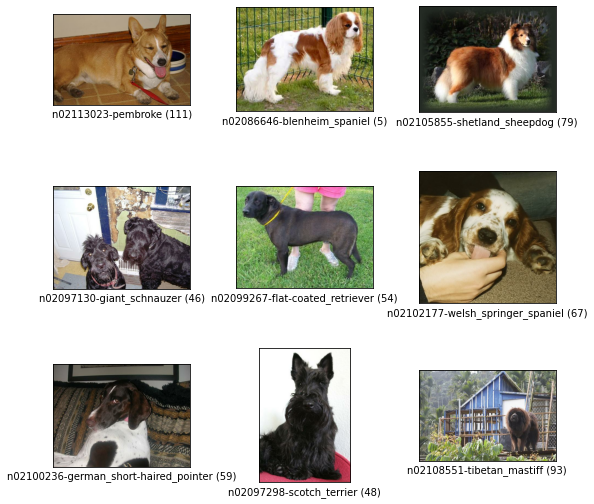

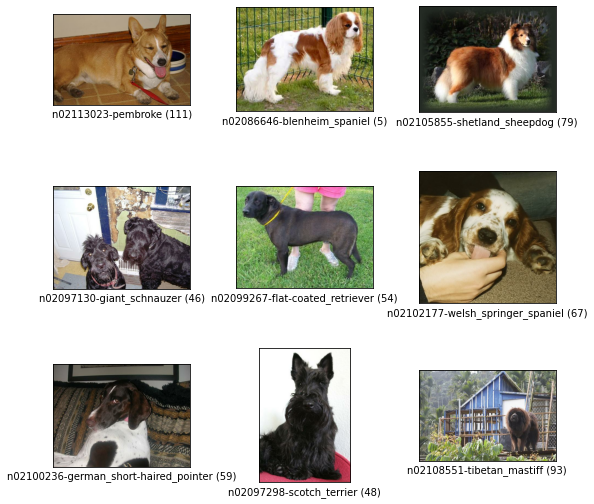

In [4]:
# train set 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_train, ds_info)

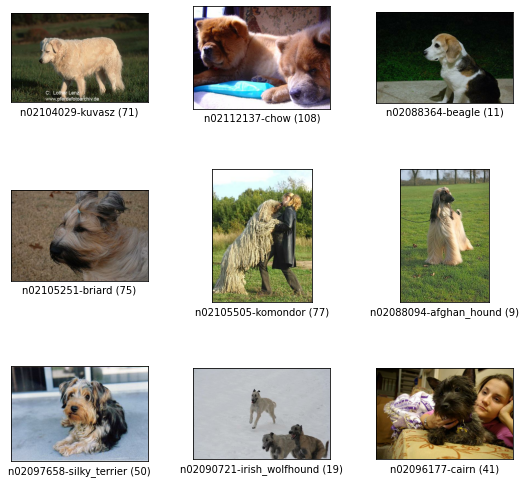

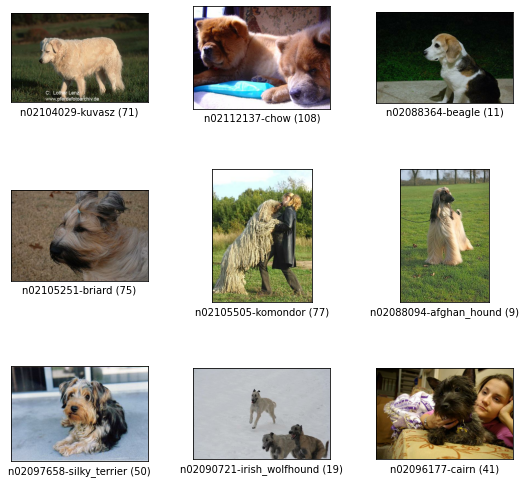

In [5]:
# test set 이미지의 클래스와 그 인덱스(index) 확인
tfds.show_examples(ds_test, ds_info)

## 10-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

In [6]:
# feature 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- image, label : 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스
- bbox(바운딩 박스) : 물체의 위치를 사각형 영역으로 표기하는 방법. BBoxFeature이라는 타입으로 정의되어 있다. -> tfds에서의 [BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)는 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]을 의미한다.

#### <span style='background-color: #fff5b1'>바운딩 박스를 표시하는 방법</span>
1. 'xywh' : 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법. x, y가 중심점이 아니라 좌측 상단의 점을 나타낼 때도 있다. -> (x_center, y_center, width, height)
2. 'minmax' : 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법. 보통 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기한다. -> (x_min, x_max, y_min, y_max)
3. 그 외 : 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등이 있다.

## 10-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기
- Grad-CAM 모델 만들기 : 미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반 -> pooling layer 뒤에 소프트맥스 레이어(소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어)를 붙이기

In [7]:
# CAM용 기본모델
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


- [기본 ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)
- CAM에서 ResNet50 : 마지막 fully connected layer 대신 GAP을 사용 -> include_top=False, pooling='avg'

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

- conv5_block3_out의 output이 feature map이다. 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 된다.

## 10-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

In [9]:
# 전처리 함수
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 배치구성 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- input image에 bbox 정보가 포함되어 있지만, CAM 모델의 학습에는 bbox 정보가 필요가 없어 normalize_and_resize_img과정에서 제외했다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다.

In [10]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양 확인 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# 컴파일
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [12]:
# 학습
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 193s 202ms/step - loss: 2.2481 - accuracy: 0.4362 - val_loss: 3.5658 - val_accuracy: 0.2008
Epoch 2/2
750/750 [==============================] - 155s 206ms/step - loss: 0.6325 - accuracy: 0.8311 - val_loss: 1.1844 - val_accuracy: 0.6505


In [13]:
# 학습시킨 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 10-6. CAM

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

- CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 한다.

100


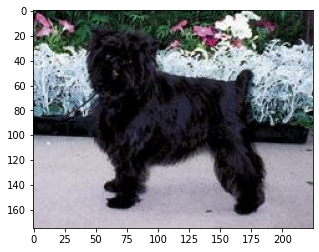

In [15]:
# test 할 이미지 불러오기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [16]:
# 미리 학습한 모델 불러오기
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

### CAM을 생성하기
- (1) <span style='background-color: #dcffe4'>특성 맵</span>, (2) <span style='background-color: #dcffe4'>클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치</span>, 그리고 (3) <span style='background-color: #dcffe4'>원하는 클래스의 출력값</span>이 필요하다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하기 위해 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 한다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.
- generate_cam() : conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산한다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해준다.

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 GAP 이전 Convolution layer의 output을 얻을 수 있다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타난다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

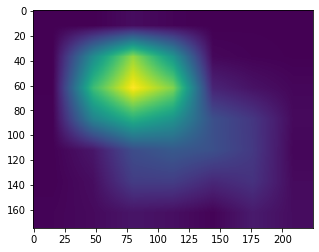

In [18]:
# CAM 얻기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [19]:
# CAM 이미지와 원본 이미지 합치기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

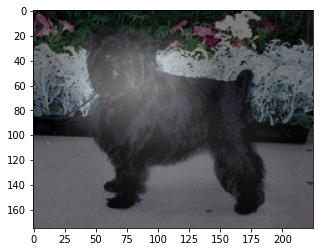

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 보인다.

## 10-7. Grad-CAM

84


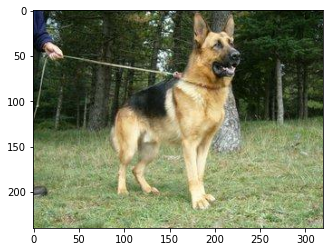

In [21]:
# 새로운 test 할 이미지 불러오기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### Grad-CAM 생성하기
- grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻얻는다.
- CAM 함수와 달리, Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.
- generate_grad_cam() : 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용한다.

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의한다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가한다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값 얻기
        output = conv_output[0] # 원하는 layer의 output 얻기
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient 얻기

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight 구하기
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map 얻기
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

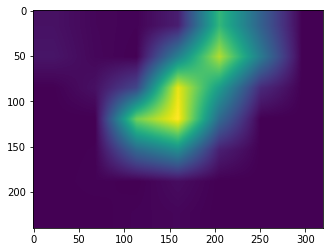

In [23]:
# 여러 레이어의 CAM 이미지 뽑아보기
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

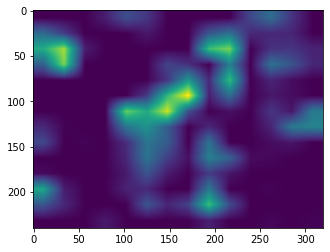

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

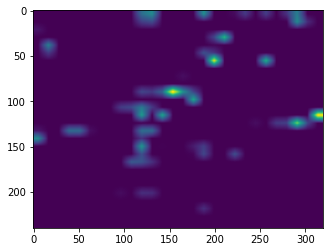

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 10-8. Detection with CAM
### 바운딩 박스
- CAM에서 물체의 위치를 찾는 detection 하기

11


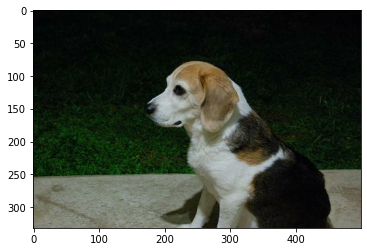

In [26]:
# 새로운 test 할 이미지 불러오기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

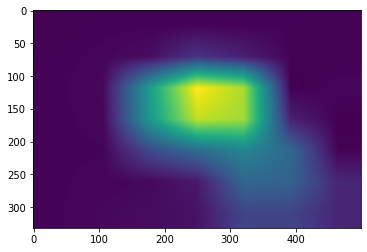

In [27]:
# cam 이미지 뽑기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [28]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

- get_bbox() 함수 : 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다. boxPoints()로 이를 꼭지점으로 바꾼다. 마지막에는 int 자료형으로 변환한다.

In [29]:
rect = get_bbox(cam_image)
rect

array([[112, 330],
       [112,  40],
       [498,  40],
       [498, 330]])

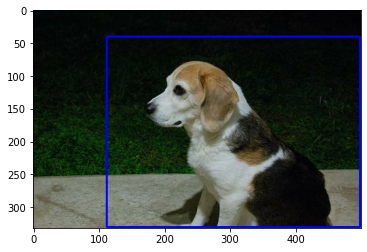

In [30]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union
- CAM과 Grad-CAM를 통해서 얻은 바운딩 박스와 정답 데이터인 바운딩 박스 비교, 평가하는 지표

![IoU](https://user-images.githubusercontent.com/116326867/215936680-7ba205b8-c376-4d61-b19e-4ad7ad4dd959.png)
- IoU(Intersection over Union) : 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값이다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.
- [IoU 설명 영상](https://www.youtube.com/watch?v=ANIzQ5G-XPE&t=4s)

In [31]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어진다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [32]:
# rect를 minmax bbox 형태로 치환하기
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.12048192771084337, 0.224, 0.9939759036144579, 0.996]

In [33]:
# ground truth bbox
item['objects']['bbox']

array([[0.22289157, 0.326     , 0.9909639 , 0.916     ]], dtype=float32)

In [34]:
# 두 결과를 바탕으로 IoU 계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [35]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6720118651927657